# Module 2 - Tutorial 1: Generalized Linear Models

In this tutorial we will investigate statistical models for neural dynamics. 
We will first focus on calculating the maximum likelihood estimator of neural firing rates before constructing NLP models, one of the most prevalent statistical models in Computational Neuroscience. You will yet again work with spike triggered averages (STAs), a concept that should be familiar from last year's Computational Neuroscience class.

This tutorial is composed of two parts - the second part that we will discuss next week will be build upon this week's tutorial.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from utils import make_filter, convolution, minimize

References and extra reading:

GLM Tutorial from Jonathan Pillow : https://github.com/pillowlab/GLMspiketraintutorial

GLM Paper Pillow et al., Nature 2008: https://www.nature.com/articles/nature07140

Proof that GLMs (under certain conditions) are guaranteed to have convex loss functions : 
http://www.cns.nyu.edu/pub/lcv/paninski04b.pdf

Proof that STA is a linear estimate of the receptive field:
https://neurophysics.ucsd.edu/courses/physics_171/Chichilnisky2001.pdf


### Part 1 : Maximum likelihood (ML) estimators
1) A statistical model for a neuron's spiking behaviour is the Poisson process. If we assume that the neuron's spike counts are drawn from a _homogenous_ Poisson process, then given a timebin of size $\Delta t$ and constant firing rate $r$, the response $y$ in a particular  timebin $t$ and trial $i$ is:

$y^i_t \sim \text{Poisson}(r\Delta t)$

The PMF in this case would be:

$p(y) = \frac{(r\Delta t)^y \exp(-r\Delta t)}{y!}$

a) Use the PMF to write down the likelihood of a spike train with $T$ timebins and $L$ trials, generated from a homogenous Poisson process as described above. Apply the logerithm to get the log likelihood. 

Likelihood:

<details>
    
In a homogenous Poisson process, we assume that the spike counts in each timebin and trials are _independent_, so the likelihood of a full spike train is simply the product of the probability of spike counts in each timebin and trial

$p(y) = p(y_{1:T, 1:L}) = \prod_{t=1}^T\prod_{i=1}^L \frac{(r\Delta t)^{y^i_t} \exp(-r\Delta t)}{y^i_t!}$  

Log-Likelihood:

<details>

$ \begin{align} 
\log p(y_{1:T, 1:L}) &= \sum_{t=1}^T\sum_{i=1}^L \log\frac{(r\Delta t)^{y^i_t} \exp(-r\Delta t)}{y^i_t!} \\
                     &= \sum_{t,i=1}^{T,L} y^i_t \log(r\Delta t) - r\Delta t - \log(y^i_t!)
 \end{align}$

b) Find the maximum likelihood (ML) estimator of $r$.

<details>

$ \begin{align} 
\frac{d}{dr} \log p(y) &= \sum_{t,i=1}^{T,L} (y^i_t \frac{1}{r\Delta t}\cdot \Delta t - \Delta t )\\
                       &= \sum_{t,i=1}^{T,L} (\frac{y^i_t}{r}) - TL\Delta t
\end{align}$

Maximise:

<details>

$\frac{d}{dr} \log p(y) = 0 \\
\Rightarrow$ 

$ \begin{align} 
TL\Delta t &= \sum_{t,i=1}^{T,L} \frac{y^i_t}{r} \\
r_{ml} &= \frac{1}{TL\Delta t} \sum_{t,i=1}^{T,L} y^i_t
\end{align}$

Does this make sense intuitively?

<details>
empirical mean across all trials and the duration


c) Repeat a) and b) for an inhomogenous Poisson process.

<details>

$p(y_t^i|\mu(t), \Delta t) = \frac{(\mu(t)\Delta t)^y \exp(-\mu(t)\Delta t)}{y!}$  
MLE fails here without further assumptions (e.g. parametric form of $\mu(t)$ or $\mu(t)$ being constant or linear over subintervals)

d) Now assume that the spikes are drawn from a Bernoulli distribution instead of a Poisson distribution in the homogeneous case. What is the log-likelihood and ML estimator of $r$ in this case?

$y_t^i \sim \mathrm{Bernoulli}(r\Delta t)$  
PMF Bernoulli:

<details>
We now assume $\Delta t$ to be so small, such that $r\Delta t \in 0,1$  
    
$p(y_t^i|r\Delta t) = (r\Delta t)^{y_t^i}(1-r\Delta t)^{1-y_t^i} \quad y \in 0,1$  
    
Log-likelihood:

<details>
    
$ \begin{align} 
\log p(y_{bern}) &= \sum_{t,i=1}^{T,L} (\log(r\Delta t)^{y_t^i}(1-r\Delta t)^{1-y_t^i}) \\
                     &= \sum_{t,i=1}^{T,L} (y^i_t \log(r\Delta t) + (1-y_t^i)\log(1-r\Delta t)) \\
                     &= \sum_{t,i=1}^{T,L} (y^i_t [\log(r\Delta t) - \log(1-r\Delta t)]) + TL \log(1-r\Delta t)
 \end{align}$  
    


ML estimator of r:

<details>
    
$\frac{d}{dr} \log p(y) = \sum_{t,i=1}^{T,L}  (y^i_t \left( \frac{\Delta t}{r\Delta t} - \frac{-\Delta t}{1-r\Delta t} \right)) + TL \frac{-\Delta t}{1-r\Delta t} $
 
$\frac{d}{dr} \log p(y) = 0 \\
 \Rightarrow$ 



<details>


$ \sum_{t,i=1}^{T,L} (y^i_t \left( \frac{1}{r\Delta t} + \frac{1}{1-r\Delta t} \right)) - \frac{TL}{1-r\Delta t} = 0   $         
$ \sum_{t,i=1}^{T,L} \frac{y^i_t}{TL} \left( \frac{1-r\Delta t}{r\Delta t} + 1 \right) = 1   $         

<details>


$ \sum_{t,i=1}^{T,L} \frac{y^i_t}{TL} \left( \frac{1-r\Delta t+r\Delta t}{r\Delta t}  \right) = 1   $       
$ r_{ml} = \frac{1}{TL\Delta t} \sum_{t,i=1}^{T,L} y^i_t $ 

___

2) Now assume that the firing rate in the inhomogenous model is dependent on an input stimulus $x$, via a weight $\omega$ and an offset $b$.

$r_t = \omega x_{t} + b$

$y_t \sim Poisson(r_t\Delta t)$

Write down the log likelihood for this model and its gradients with respect to $\omega$ and $b$  

Log-likelihood:

<details>
 
$r_t = \omega x_t +b $  
$y_t^i \sim \mathrm{Poisson}(r_t\Delta t)$  

$\log p(y_{poiss, stim}) = \sum_{t,i=1}^{T,L} (y_t^i \log[(\omega x_t + b)\Delta t] - (\omega x_t + b)\Delta t - \log(y_t^i!)$)

Gradient wrt. $\omega$: 

<details> 
    
Gradients with respect to $\omega$ and $b$   
$\frac{d}{d\omega} \log p(y) = \sum_{t,i=1}^{T,L}( y^i_t \frac{x_t \Delta t}{(\omega x_t + b)\Delta t} - x_t \Delta t$  )


Gradient wrt. $b$: 

<details> 

$\frac{d}{db} \log p(y) = \sum_{t,i=1}^{T,L} (y^i_t \frac{\Delta t}{(\omega x_t + b)\Delta t} - \Delta t$)

___

3) We can add a nonlinearity to the model to impose constraints on the firing rate. For example, with the Poisson model, we can rewrite the firing rate $r$ as follows

$z_t = \omega x_t + b \\
r_t = \exp(z_t)$

to ensure that the firing rate is always positive. Enforcing this constraint via a nonlinear function means that our model in _no longer linear_, as in the previous examples. However, this model, called a Linear Nonlinear Poisson (LNP), is a _generalized_ linear model (GLM). Its likelihood is guaranteed to have a global optimum with respect to the model parameters.

a) Write down the log likelihood of the LNP model and its gradients with respect to $\omega$ and $b$.

$z_t = \omega x_t +b $  
$r_t = \exp(z_t) \quad$    NL $\rightarrow$LNP model

$y_t = \mathrm{Poisson}[\exp(\omega x_t +b)\Delta t]$

Log-Likelihood:


<details>
    
$ \begin{align} 
\log p(y_{NLP}) &= \sum_{t,i=1}^{T,L} \log \frac{[\exp{(\omega x_t + b)\Delta t]^{y_t^i}}\exp[-\exp(\omega x_t + b)\Delta t]}{y_t^i!} \\
                &= \sum_{t,i=1}^{T,L} y_t^i (\omega x_t + b + \log(\Delta t)) -\exp(\omega x_t + b)\Delta t - \log({y_t^i!})
\end{align}$  
    
Gradients:
    

<details>

$\frac{d}{d\omega} \log p(y) = \sum_{t,i=1}^{T,L} (y^i_t x_t - x_t \Delta t \exp(\omega x_t + b) )$  
$\frac{d}{db} \log p(y) = \sum_{t,i=1}^{T,L}( y^i_t - \Delta t \exp(\omega x_t + b) )$

___
### Part 2:   Construct a linear-nonlinear (LNP) model
So far, we have seen a linear and a linear-nonlinear model where the spike count in a given timebin is dependent only on the stimulus in that timebin. To get more realistic spike counts on the model, the firing rate should be dependent on the stimulus-history. Hence, the input stimulus to the model at each timebin is now a vector of length $K$. $K$ is number of timebins in the past during which the neuron "integrates" the effect of the stimulus, weighted by the vector $\boldsymbol{\omega}$ of size $K$:

$z_t = \sum_{k=1}^K \omega_k x_{t-k} + b$

The operation described in the equation above is called a _convolution_ and the parameter $\boldsymbol{\omega}$ is the neuron's _receptive field_.

The firing rate vector across all timebins, $\mathbf{r}$, and responses, $\mathbf{y}$, in a linear-nonlinear Poisson (LNP) process for input stimulus $\mathbf{x}$ is given by:

$\begin{align}
\mathbf{z} &= \boldsymbol{\omega} * \mathbf{x} + b \\
\mathbf{r} &= \exp(\mathbf{z}) \\
\mathbf{y} &\sim Poisson(\mathbf{r})
\end{align}$


where $\boldsymbol{\omega}$ is the convolutional filter or receptive field, $b$ is a baseline offset, $*$ is the convolution operation.  

**Questions:**

a) Make a filter for this model using the make_filter() method from utils.py. You can change the parameters to get different filter shapes The filter shown below was generated with these parameters:  

lags=25, mu1=3., mu2=8., s1=1., s2=5., eta=.2  

You can also change the number of stimulus lags to see the effect it has on generated responses.  

Use the convolution() method from utils.py to implement the convolution step, or (optionally) try writing your own method.

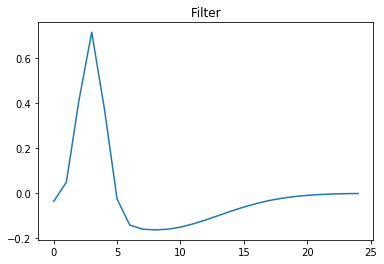

In [2]:
# a) Set the filter and baseline values
stim_lags = 25
dt = 1
# make filter
_filter = make_filter(lags=25, mu1=3., mu2=8., s1=1., s2=5., eta=.2)

plt.title("Filter")
plt.plot(_filter)
plt.show()

b) Simulate responses $\mathbf{y}$ from this model to 200 repeats of an impulse stimulus of length "stim_lags + 1" (1 followed by 0s in all other timebins). Calculate the PSTH of these responses and use them to extract estimates of $\boldsymbol{\omega}$ and $b$. 

Stimulus shape : (26,)
Tiled stimulus shape : (200, 26)


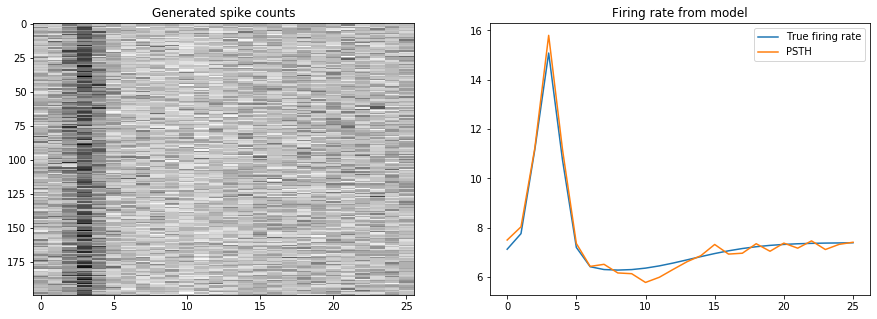

In [3]:
# Sample code

# Generate stimulus
stim = np.zeros(stim_lags+1)
stim[0] = 1

baseline = 2.

print("Stimulus shape :", stim.shape)
#Make repeats of stimulus
stim = np.tile(stim, 200).reshape(200, -1) # -> make it n_trials

print("Tiled stimulus shape :", stim.shape)


# Calculate firing rate using the convolution function
z = convolution(_filter, stim) + baseline
# Apply the non-linearity 
r = np.exp(z)
# Simulate from model using np.random.poisson
y = np.random.poisson(r * dt)

# Plot spike counts, predicted firing rate and PSTH
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title("Generated spike counts")
ax1.imshow(y, cmap='binary', aspect='auto')

ax2.set_title("Firing rate from model")
ax2.plot(r[0], label="True firing rate")
ax2.plot(y.mean(0), label = "PSTH")
ax2.legend()

Baseline estimate: 2.002830


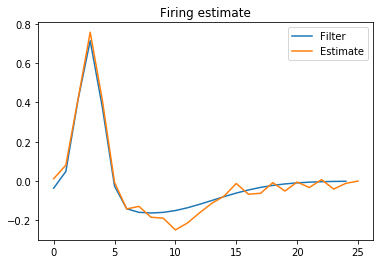

In [4]:
# Infer the baseline
# Hint: You can get a decent estimate of the baseline if you look at the PSTH at a point where the spike response is close to zero.

baseline_estimate = np.log(y.mean(0)[-1])
print("Baseline estimate: %f" %baseline_estimate)

# Infer w and compare it with the filter
w_estimate = np.log(y.mean(0)) - baseline_estimate

plt.title("Firing estimate")
plt.plot(_filter, label="Filter")
plt.plot(w_estimate, label = "Estimate")
plt.legend()

c) Simulate responses $\mathbf{y}$ from this model to 200 repeats of Gaussian white noise stimulus of length 100. Calculate the peristimulus time histogram (PSTH) of these responses and compare it to the rate $\mathbf{r}$ from the model -- the 2 should match.

Stimulus shape : (100,)
Tiled stimulus shape : (200, 100)


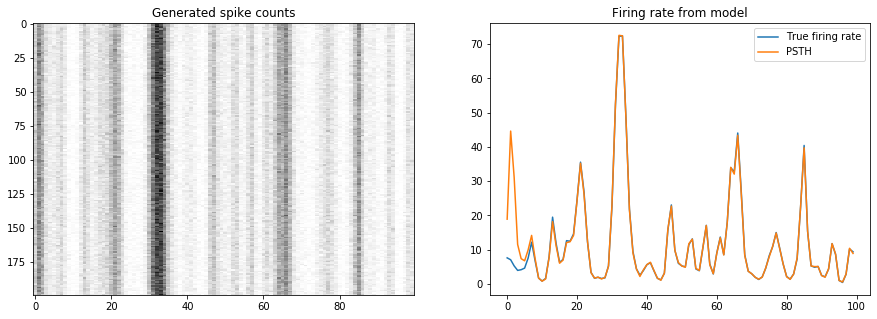

In [5]:
# Sample code

# Generate stimulus
stim = np.random.normal(size=100)

baseline = 2.

print("Stimulus shape :", stim.shape)
#Make repeats of stimulus
stim = np.tile(stim, 200).reshape(200, -1) # -> make it n_trials

print("Tiled stimulus shape :", stim.shape)


# Calculate firing rate using the convolution function
z = convolution(_filter, stim) + baseline
# Apply the non-linearity 
r = np.exp(z)
# Simulate from model using np.random.poisson
y = np.random.poisson(r * dt)

# Plot spike counts, predicted firing rate and PSTH
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title("Generated spike counts")
ax1.imshow(y, cmap='binary', aspect='auto')

ax2.set_title("Firing rate from model")
ax2.plot(r[0], label="True firing rate")
ax2.plot(y.mean(0), label = "PSTH")
ax2.legend()

d) Simulate responses from this model to Gaussian white noise input of length 1000. Here we calculate the spike triggered average (STA) using the Hankel matrix. Feel free to write a function that calculates the STA yourself. Compare the estimate with the groundtruth $\boldsymbol{\omega}$. Do they match? How can you improve this estimate?

Stimulus shape : (1000,)
Tiled stimulus shape : (200, 1000)


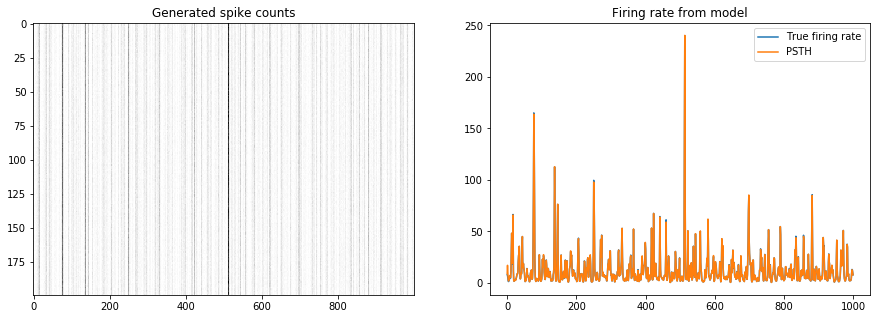

In [6]:
# Sample code
stim_len = 1000
# Generate stimulus
stim = np.random.normal(size=stim_len)
baseline = 2.

print("Stimulus shape :", stim.shape)
#Make repeats of stimulus
n_trials = 200
stim = np.tile(stim, n_trials).reshape(n_trials, -1)

print("Tiled stimulus shape :", stim.shape)


# Calculate firing rate using the convolution function
z = convolution(_filter, stim) + baseline
# Apply the non-linearity 
r = np.exp(z)
# Simulate from model using np.random.poisson
y = np.random.poisson(r * dt)

# Plot spike counts, predicted firing rate and PSTH
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title("Generated spike counts")
ax1.imshow(y, cmap='binary', aspect='auto')

ax2.set_title("Firing rate from model")
ax2.plot(r[0], label="True firing rate")
ax2.plot(y.mean(0), label = "PSTH")
ax2.legend()

___
### Note : Calculating the spike triggered average (STA)
The STA is the stimulus shape, that on average, elicits a response. It is a linear estimate of the convolution filter. To calculate the STA we average over all the stimulus vectors (of a fixed length) that preceded a timebin, and weighted by the number of spikes in that timebin. Since we already know the length of the convolution filter, the most sensible thing to do is to fix the length of the stimulus vectors at this value $K$. However, you can try calculating the STA with other lengths. Thus:

$\text{STA} = \frac{\sum_{t=K}^{T} \mathbf{y}_t  \mathbf{x}_{t-K\text{ }:\text{ }t}}{\sum_{t=K}^{T} \mathbf{y}_t}$

where $\mathbf{x}$ is the stimulus and $\mathbf{y}$ is the response vector and $k$ is the fixed length of the stimulus preceding a spike.

If we construct a matrix by stacking all the stimulus vectors that precede each timebin, we get a [Hankel matrix](https://en.wikipedia.org/wiki/Hankel_matrix). Look at the hankel() method in utils.py, or at the docs for a scipy.linalg.hankel() to see how this is implemented.
We can use the Hankel matrix $\mathbf{X}$ to calcualte the STA directly by matrix-vector multiplication with the response vector $\mathbf{y}$:

$\text{STA} = \frac{1}{\sum_{t}^{T} \mathbf{y}_t}\mathbf{y}\cdot \mathbf{X} $

Note that we can also use the Hankel matrix to convert convolution operations into matrix multiplication operations.

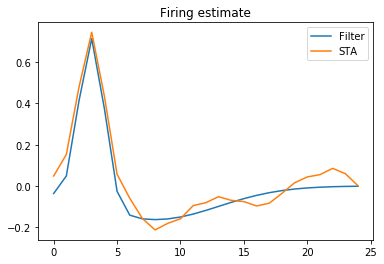

In [7]:
from utils import hankel
X = hankel(stim_lags, stim)
# Calculate STA
sta = y.flatten().dot(X) / y.sum()    

plt.title("Firing estimate")
plt.plot(_filter, label="Filter")
plt.plot(sta, label = "STA")
plt.legend()

In [8]:
print('Hankel matrix dimensions: ', X.shape) # -> take pen and paper and check Conv -> Matrix multiplication at home

Hankel matrix dimensions:  (200000, 25)


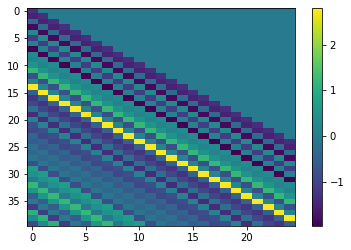

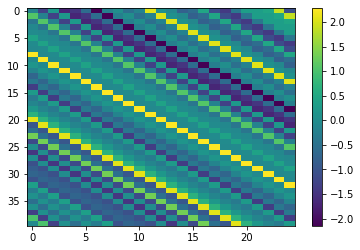

In [9]:
plt.figure()
plt.imshow(X[0:40,:], aspect='auto')
plt.colorbar()
plt.figure()
plt.imshow(X[-40:,:], aspect='auto')
plt.colorbar()

### Part 2.5: Construct a spike-history dependent LNP model

For generating even more realistic spike counts from the model, the firing rate should also depend on the spike-history. Thus, at every timebin, the model should also receive as input, its own previous spikes (a vector of length $N$), weighted by the vector $\mathbf{h}$ of size $N$:


$\begin{align}
r_t &= exp(\sum_{k=1}^K \omega_k x_{t-k} + \sum_{n=1}^N h_n y_{t-n} +  b)\\
y_t &\sim \text{Poisson}(r\Delta t)
\end{align}$

Algorithmically, this means that we can only generate spikes sequentially, rather than all at once, as in the previous examples. 

a) Repeat steps a) and c) from Part 2 for this model, i.e. make two filters for this model using the make_filter() method from utils.py Simulate responses $\mathbf{y}$ from this model to 200 repeats of a Gaussian white noise stimulus of length 100. Calculate the peristimulus time histogram (PSTH) of these responses and compare it to the rate $\mathbf{r}$ from the model.

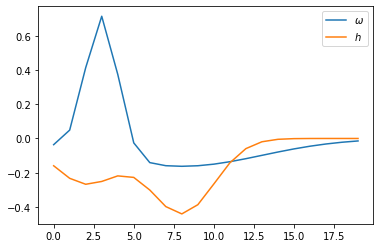

In [12]:
# Sample code

# Make filters for ω and h, set baseline
stim_lags = 20
hst_lags = 20
baseline = 2.
dt = 1

_filter_w = make_filter(lags=stim_lags, mu1=3., mu2=8., s1=1., s2=5., eta=.2)
_filter_h = - make_filter(lags=hst_lags, mu1=8., mu2=2., s1=2., s2=2., eta=-.6)

plt.plot(_filter_w, label='$\omega$')
plt.plot(_filter_h, label='$h$')
plt.legend()

In [13]:
# Generate stimulus
stim = np.random.normal(size=100)
stim = np.tile(stim, 200).reshape(200, -1)

In [14]:
# Calculate response

y = np.zeros_like(stim)
r = np.zeros_like(stim)

for i in range(stim.shape[0]):
    
    for t in range(stim.shape[1]):
        
        # calculate receptive field filter
        rf = 0
        for k in range(stim_lags):
            rf += _filter_w[k] * stim[i, t - k]
        
    
        # calculate spike history dependent filter
        hst = 0
        for n in range(hst_lags):
            hst += _filter_h[n] * y[i, t - n]
        
        # Calculate firing rate
        r[i, t] = np.exp(rf + hst + baseline) # GLM - remember everyting within the non linearity is linear
        
        # Calculate response
        y[i, t] = np.random.poisson(dt * r[i, t])

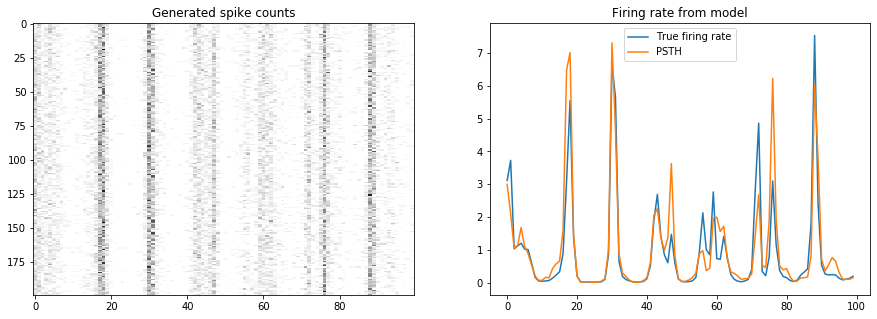

In [15]:
# Plot spike counts, predicted firing rate and PSTH
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title("Generated spike counts")
ax1.imshow(y, cmap='binary', aspect='auto')


ax2.set_title("Firing rate from model")
ax2.plot(r[0], label="True firing rate")
ax2.plot(y.mean(0), label = "PSTH")
ax2.legend()